[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1t0_4BxEJ0XncyYvn_VyEQhxwNMvtSUNx?usp=sharing)

In [1]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
from copy import deepcopy
from pathlib import Path
from gsat import GSAT, ExtractorMLP
from utils import get_data_loaders, get_model, set_seed, Criterion, init_metric_dict, load_checkpoint
from trainer import run_one_epoch, update_best_epoch_res, get_viz_idx, visualize_results
from datetime import datetime


Using backend: pytorch


In [2]:
# dataset_name = 'ba_2motifs'
dataset_name = 'mnist'
# model_name = 'GIN'

#dataset_name = 'ogbg_molhiv'
model_name = 'GIN'

method_name = 'GSAT'
cuda_id = 0
seed = 0
set_seed(seed)

In [3]:
data_dir = Path('../data/')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

if model_name == 'GIN':
    model_config = {'model_name': 'GIN', 'hidden_size': 64, 'n_layers': 2, 'dropout_p': 0.3, 'use_edge_attr': False}
else:
    assert model_name == 'PNA'
    model_config = {'model_name': 'PNA', 'hidden_size': 80, 'n_layers': 4, 'dropout_p': 0.3, 'use_edge_attr': False, 
                    'atom_encoder': False, 'aggregators': ['mean', 'min', 'max', 'std'], 'scalers': False}
    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (datetime.now().strftime("%m_%d_%Y-%H_%M_%S") + '-' + dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)


In [4]:
loaders, test_set, x_dim, edge_attr_dim, num_class, aux_info = get_data_loaders(data_dir, dataset_name, batch_size=128, random_state=seed,
                                                                                splits={'train': 0.8, 'valid': 0.1, 'test': 0.1}, 
                                                                                mutag_x=True if dataset_name == 'mutag' else False)
model_config['deg'] = aux_info['deg']

/home/zz/anaconda3/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/zz/anaconda3/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppre

[INFO] Using default splits!
[INFO] Calculating degree...


In [5]:
clf = get_model(x_dim, edge_attr_dim, num_class, aux_info['multi_label'], model_config, device)
extractor = ExtractorMLP(model_config['hidden_size'], learn_edge_att=False).to(device)
optimizer = torch.optim.Adam(list(extractor.parameters()) + list(clf.parameters()), lr=1e-3, weight_decay=3.0e-6)
criterion = Criterion(num_class, aux_info['multi_label'])
gsat = GSAT(clf, extractor, criterion, optimizer, learn_edge_att=False, final_r=0.7)
from utils import process_data
data = process_data(next(iter(loaders['train'])),model_config['use_edge_attr'])

[INFO] Using multi_label: False


In [6]:
from thop import profile
from thop import clever_format
flops, params = profile(gsat, inputs=[data.to(gsat.device)])
clever_format([flops, params], '%.3f')

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


('460.953M', '34.571K')

In [7]:
for epoch in range(100):
    train_res = run_one_epoch(gsat, loaders['train'], epoch, 'train', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    valid_res = run_one_epoch(gsat, loaders['valid'], epoch, 'valid', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    test_res = run_one_epoch(gsat, loaders['test'], epoch, 'test', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    
    metric_dict = update_best_epoch_res(gsat, train_res, valid_res, test_res, metric_dict, dataset_name, epoch, model_dir)
    print(f'[Seed {seed}, Epoch: {epoch}]: Best Epoch: {metric_dict["metric/best_clf_epoch"]}, '
          f'Best Val Pred ACC/ROC: {metric_dict["metric/best_clf_valid"]:.3f}, Best Test Pred ACC/ROC: {metric_dict["metric/best_clf_test"]:.3f}, '
          f'Best Test X AUROC: {metric_dict["metric/best_x_roc_test"]:.3f}')
    print('='*50)
    print('='*50)

[Seed 0, Epoch: 0]: gsat_train finished, loss: 2.847, pred: 2.399, info: 0.448, clf_acc: 0.264, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.53it/s]
[Seed 0, Epoch: 0]: gsat_valid finished, loss: 1.633, pred: 1.601, info: 0.032, clf_acc: 0.480, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  6.78it/s]
[Seed 0, Epoch: 0]: gsat_test  finished, loss: 2.989, pred: 2.952, info: 0.037, clf_acc: 0.267, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:11<00:00,  6.59it/s]


[Seed 0, Epoch: 0]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 1]: gsat_train finished, loss: 1.514, pred: 1.382, info: 0.132, clf_acc: 0.525, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.59it/s]
[Seed 0, Epoch: 1]: gsat_valid finished, loss: 1.188, pred: 1.136, info: 0.052, clf_acc: 0.613, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.88it/s]
[Seed 0, Epoch: 1]: gsat_test  finished, loss: 3.013, pred: 2.963, info: 0.050, clf_acc: 0.314, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.30it/s]


[Seed 0, Epoch: 1]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 2]: gsat_train finished, loss: 1.157, pred: 1.061, info: 0.096, clf_acc: 0.640, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.63it/s]
[Seed 0, Epoch: 2]: gsat_valid finished, loss: 0.932, pred: 0.858, info: 0.074, clf_acc: 0.717, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.82it/s]
[Seed 0, Epoch: 2]: gsat_test  finished, loss: 3.096, pred: 3.024, info: 0.072, clf_acc: 0.332, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 11.79it/s]


[Seed 0, Epoch: 2]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 3]: gsat_train finished, loss: 1.021, pred: 0.931, info: 0.091, clf_acc: 0.688, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.27it/s]
[Seed 0, Epoch: 3]: gsat_valid finished, loss: 0.906, pred: 0.824, info: 0.082, clf_acc: 0.730, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.60it/s]
[Seed 0, Epoch: 3]: gsat_test  finished, loss: 3.898, pred: 3.817, info: 0.081, clf_acc: 0.315, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


[Seed 0, Epoch: 3]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 4]: gsat_train finished, loss: 0.946, pred: 0.856, info: 0.090, clf_acc: 0.714, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.64it/s]
[Seed 0, Epoch: 4]: gsat_valid finished, loss: 0.860, pred: 0.775, info: 0.085, clf_acc: 0.734, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.47it/s]
[Seed 0, Epoch: 4]: gsat_test  finished, loss: 4.147, pred: 4.064, info: 0.084, clf_acc: 0.314, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


[Seed 0, Epoch: 4]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 5]: gsat_train finished, loss: 0.896, pred: 0.805, info: 0.091, clf_acc: 0.732, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.56it/s]
[Seed 0, Epoch: 5]: gsat_valid finished, loss: 0.767, pred: 0.678, info: 0.088, clf_acc: 0.773, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.22it/s]
[Seed 0, Epoch: 5]: gsat_test  finished, loss: 4.239, pred: 4.151, info: 0.088, clf_acc: 0.324, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.74it/s]


[Seed 0, Epoch: 5]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 6]: gsat_train finished, loss: 0.862, pred: 0.771, info: 0.091, clf_acc: 0.743, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.72it/s]
[Seed 0, Epoch: 6]: gsat_valid finished, loss: 0.947, pred: 0.854, info: 0.093, clf_acc: 0.735, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.24it/s]
[Seed 0, Epoch: 6]: gsat_test  finished, loss: 5.439, pred: 5.346, info: 0.093, clf_acc: 0.298, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.37it/s]


[Seed 0, Epoch: 6]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 7]: gsat_train finished, loss: 0.823, pred: 0.731, info: 0.092, clf_acc: 0.760, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.68it/s]
[Seed 0, Epoch: 7]: gsat_valid finished, loss: 0.837, pred: 0.744, info: 0.093, clf_acc: 0.758, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.90it/s]
[Seed 0, Epoch: 7]: gsat_test  finished, loss: 5.200, pred: 5.107, info: 0.093, clf_acc: 0.302, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.74it/s]


[Seed 0, Epoch: 7]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 8]: gsat_train finished, loss: 0.796, pred: 0.703, info: 0.092, clf_acc: 0.767, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:17<00:00,  8.82it/s]
[Seed 0, Epoch: 8]: gsat_valid finished, loss: 0.733, pred: 0.639, info: 0.094, clf_acc: 0.789, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.42it/s]
[Seed 0, Epoch: 8]: gsat_test  finished, loss: 4.541, pred: 4.447, info: 0.094, clf_acc: 0.327, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.86it/s]


[Seed 0, Epoch: 8]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 9]: gsat_train finished, loss: 0.779, pred: 0.686, info: 0.093, clf_acc: 0.774, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.62it/s]
[Seed 0, Epoch: 9]: gsat_valid finished, loss: 0.683, pred: 0.587, info: 0.095, clf_acc: 0.801, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]
[Seed 0, Epoch: 9]: gsat_test  finished, loss: 4.800, pred: 4.704, info: 0.096, clf_acc: 0.325, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.27it/s]


[Seed 0, Epoch: 9]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 10]: gsat_train finished, loss: 0.862, pred: 0.669, info: 0.194, clf_acc: 0.778, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.59it/s]
[Seed 0, Epoch: 10]: gsat_valid finished, loss: 0.771, pred: 0.577, info: 0.194, clf_acc: 0.806, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.13it/s]
[Seed 0, Epoch: 10]: gsat_test  finished, loss: 4.487, pred: 4.291, info: 0.197, clf_acc: 0.331, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.54it/s]


[Seed 0, Epoch: 10]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 11]: gsat_train finished, loss: 0.841, pred: 0.650, info: 0.190, clf_acc: 0.783, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.36it/s]
[Seed 0, Epoch: 11]: gsat_valid finished, loss: 0.833, pred: 0.639, info: 0.193, clf_acc: 0.792, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.52it/s]
[Seed 0, Epoch: 11]: gsat_test  finished, loss: 5.765, pred: 5.569, info: 0.196, clf_acc: 0.302, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00,  9.97it/s]


[Seed 0, Epoch: 11]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 12]: gsat_train finished, loss: 0.825, pred: 0.636, info: 0.189, clf_acc: 0.792, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.63it/s]
[Seed 0, Epoch: 12]: gsat_valid finished, loss: 0.765, pred: 0.572, info: 0.193, clf_acc: 0.809, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.24it/s]
[Seed 0, Epoch: 12]: gsat_test  finished, loss: 5.088, pred: 4.895, info: 0.193, clf_acc: 0.325, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.71it/s]


[Seed 0, Epoch: 12]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 13]: gsat_train finished, loss: 0.814, pred: 0.626, info: 0.188, clf_acc: 0.794, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.60it/s]
[Seed 0, Epoch: 13]: gsat_valid finished, loss: 0.697, pred: 0.506, info: 0.191, clf_acc: 0.838, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.72it/s]
[Seed 0, Epoch: 13]: gsat_test  finished, loss: 5.625, pred: 5.432, info: 0.193, clf_acc: 0.320, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.30it/s]


[Seed 0, Epoch: 13]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 14]: gsat_train finished, loss: 0.796, pred: 0.610, info: 0.186, clf_acc: 0.801, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.45it/s]
[Seed 0, Epoch: 14]: gsat_valid finished, loss: 0.697, pred: 0.505, info: 0.191, clf_acc: 0.837, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.49it/s]
[Seed 0, Epoch: 14]: gsat_test  finished, loss: 5.816, pred: 5.622, info: 0.193, clf_acc: 0.317, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.38it/s]


[Seed 0, Epoch: 14]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 15]: gsat_train finished, loss: 0.789, pred: 0.604, info: 0.185, clf_acc: 0.802, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.46it/s]
[Seed 0, Epoch: 15]: gsat_valid finished, loss: 0.688, pred: 0.499, info: 0.189, clf_acc: 0.838, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.86it/s]
[Seed 0, Epoch: 15]: gsat_test  finished, loss: 4.758, pred: 4.567, info: 0.191, clf_acc: 0.347, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.22it/s]


[Seed 0, Epoch: 15]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 16]: gsat_train finished, loss: 0.789, pred: 0.604, info: 0.185, clf_acc: 0.801, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  7.96it/s]
[Seed 0, Epoch: 16]: gsat_valid finished, loss: 0.695, pred: 0.506, info: 0.189, clf_acc: 0.833, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.16it/s]
[Seed 0, Epoch: 16]: gsat_test  finished, loss: 5.189, pred: 4.997, info: 0.193, clf_acc: 0.315, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.77it/s]


[Seed 0, Epoch: 16]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 17]: gsat_train finished, loss: 0.778, pred: 0.594, info: 0.184, clf_acc: 0.804, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.49it/s]
[Seed 0, Epoch: 17]: gsat_valid finished, loss: 0.698, pred: 0.514, info: 0.183, clf_acc: 0.836, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 11.62it/s]
[Seed 0, Epoch: 17]: gsat_test  finished, loss: 5.041, pred: 4.858, info: 0.183, clf_acc: 0.346, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


[Seed 0, Epoch: 17]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 18]: gsat_train finished, loss: 0.774, pred: 0.591, info: 0.183, clf_acc: 0.803, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.60it/s]
[Seed 0, Epoch: 18]: gsat_valid finished, loss: 0.713, pred: 0.525, info: 0.188, clf_acc: 0.828, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.05it/s]
[Seed 0, Epoch: 18]: gsat_test  finished, loss: 5.723, pred: 5.537, info: 0.186, clf_acc: 0.332, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.36it/s]


[Seed 0, Epoch: 18]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 19]: gsat_train finished, loss: 0.757, pred: 0.575, info: 0.183, clf_acc: 0.812, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.37it/s]
[Seed 0, Epoch: 19]: gsat_valid finished, loss: 0.645, pred: 0.463, info: 0.181, clf_acc: 0.848, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.74it/s]
[Seed 0, Epoch: 19]: gsat_test  finished, loss: 5.596, pred: 5.415, info: 0.181, clf_acc: 0.329, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.13it/s]


[Seed 0, Epoch: 19]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 20]: gsat_train finished, loss: 0.865, pred: 0.582, info: 0.283, clf_acc: 0.810, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  8.21it/s]
[Seed 0, Epoch: 20]: gsat_valid finished, loss: 0.758, pred: 0.492, info: 0.266, clf_acc: 0.837, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.56it/s]
[Seed 0, Epoch: 20]: gsat_test  finished, loss: 6.301, pred: 6.027, info: 0.274, clf_acc: 0.308, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  8.79it/s]


[Seed 0, Epoch: 20]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.837, Best Test Pred ACC/ROC: 0.308, Best Test X AUROC: 0.000


[Seed 0, Epoch: 21]: gsat_train finished, loss: 0.853, pred: 0.581, info: 0.272, clf_acc: 0.810, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.67it/s]
[Seed 0, Epoch: 21]: gsat_valid finished, loss: 0.748, pred: 0.483, info: 0.265, clf_acc: 0.841, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.44it/s]
[Seed 0, Epoch: 21]: gsat_test  finished, loss: 6.380, pred: 6.105, info: 0.276, clf_acc: 0.306, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.80it/s]


[Seed 0, Epoch: 21]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.841, Best Test Pred ACC/ROC: 0.306, Best Test X AUROC: 0.000


[Seed 0, Epoch: 22]: gsat_train finished, loss: 0.844, pred: 0.577, info: 0.267, clf_acc: 0.808, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.34it/s]
[Seed 0, Epoch: 22]: gsat_valid finished, loss: 0.712, pred: 0.449, info: 0.263, clf_acc: 0.855, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.41it/s]
[Seed 0, Epoch: 22]: gsat_test  finished, loss: 5.809, pred: 5.539, info: 0.270, clf_acc: 0.317, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.52it/s]


[Seed 0, Epoch: 22]: Best Epoch: 22, Best Val Pred ACC/ROC: 0.855, Best Test Pred ACC/ROC: 0.317, Best Test X AUROC: 0.000


[Seed 0, Epoch: 23]: gsat_train finished, loss: 0.841, pred: 0.576, info: 0.266, clf_acc: 0.812, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  8.01it/s]
[Seed 0, Epoch: 23]: gsat_valid finished, loss: 0.716, pred: 0.461, info: 0.255, clf_acc: 0.844, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.66it/s]
[Seed 0, Epoch: 23]: gsat_test  finished, loss: 5.797, pred: 5.536, info: 0.261, clf_acc: 0.317, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00,  9.90it/s]


[Seed 0, Epoch: 23]: Best Epoch: 22, Best Val Pred ACC/ROC: 0.855, Best Test Pred ACC/ROC: 0.317, Best Test X AUROC: 0.000


[Seed 0, Epoch: 24]: gsat_train finished, loss: 0.825, pred: 0.563, info: 0.262, clf_acc: 0.813, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.27it/s]
[Seed 0, Epoch: 24]: gsat_valid finished, loss: 0.721, pred: 0.471, info: 0.250, clf_acc: 0.845, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.04it/s]
[Seed 0, Epoch: 24]: gsat_test  finished, loss: 6.134, pred: 5.872, info: 0.262, clf_acc: 0.315, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.35it/s]


[Seed 0, Epoch: 24]: Best Epoch: 22, Best Val Pred ACC/ROC: 0.855, Best Test Pred ACC/ROC: 0.317, Best Test X AUROC: 0.000


[Seed 0, Epoch: 25]: gsat_train finished, loss: 0.821, pred: 0.564, info: 0.258, clf_acc: 0.812, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:22<00:00,  7.05it/s]
[Seed 0, Epoch: 25]: gsat_valid finished, loss: 0.747, pred: 0.499, info: 0.247, clf_acc: 0.830, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s]
[Seed 0, Epoch: 25]: gsat_test  finished, loss: 5.365, pred: 5.105, info: 0.261, clf_acc: 0.340, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  7.95it/s]


[Seed 0, Epoch: 25]: Best Epoch: 22, Best Val Pred ACC/ROC: 0.855, Best Test Pred ACC/ROC: 0.317, Best Test X AUROC: 0.000


[Seed 0, Epoch: 26]: gsat_train finished, loss: 0.811, pred: 0.556, info: 0.255, clf_acc: 0.818, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:22<00:00,  6.92it/s]
[Seed 0, Epoch: 26]: gsat_valid finished, loss: 0.766, pred: 0.518, info: 0.248, clf_acc: 0.833, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.46it/s]
[Seed 0, Epoch: 26]: gsat_test  finished, loss: 5.533, pred: 5.272, info: 0.261, clf_acc: 0.319, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.23it/s]


[Seed 0, Epoch: 26]: Best Epoch: 22, Best Val Pred ACC/ROC: 0.855, Best Test Pred ACC/ROC: 0.317, Best Test X AUROC: 0.000


[Seed 0, Epoch: 27]: gsat_train finished, loss: 0.817, pred: 0.561, info: 0.255, clf_acc: 0.816, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:22<00:00,  6.88it/s]
[Seed 0, Epoch: 27]: gsat_valid finished, loss: 0.694, pred: 0.451, info: 0.243, clf_acc: 0.856, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.51it/s]
[Seed 0, Epoch: 27]: gsat_test  finished, loss: 5.220, pred: 4.961, info: 0.260, clf_acc: 0.337, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


[Seed 0, Epoch: 27]: Best Epoch: 27, Best Val Pred ACC/ROC: 0.856, Best Test Pred ACC/ROC: 0.337, Best Test X AUROC: 0.000


[Seed 0, Epoch: 28]: gsat_train finished, loss: 0.797, pred: 0.545, info: 0.252, clf_acc: 0.821, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  8.10it/s]
[Seed 0, Epoch: 28]: gsat_valid finished, loss: 0.653, pred: 0.413, info: 0.241, clf_acc: 0.864, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.90it/s]
[Seed 0, Epoch: 28]: gsat_test  finished, loss: 5.708, pred: 5.452, info: 0.255, clf_acc: 0.340, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.74it/s]


[Seed 0, Epoch: 28]: Best Epoch: 28, Best Val Pred ACC/ROC: 0.864, Best Test Pred ACC/ROC: 0.340, Best Test X AUROC: 0.000


[Seed 0, Epoch: 29]: gsat_train finished, loss: 0.793, pred: 0.541, info: 0.252, clf_acc: 0.822, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.47it/s]
[Seed 0, Epoch: 29]: gsat_valid finished, loss: 0.694, pred: 0.448, info: 0.246, clf_acc: 0.856, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.53it/s]
[Seed 0, Epoch: 29]: gsat_test  finished, loss: 5.300, pred: 5.041, info: 0.260, clf_acc: 0.334, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.43it/s]


[Seed 0, Epoch: 29]: Best Epoch: 28, Best Val Pred ACC/ROC: 0.864, Best Test Pred ACC/ROC: 0.340, Best Test X AUROC: 0.000


[Seed 0, Epoch: 30]: gsat_train finished, loss: 0.800, pred: 0.550, info: 0.250, clf_acc: 0.819, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:22<00:00,  6.99it/s]
[Seed 0, Epoch: 30]: gsat_valid finished, loss: 0.646, pred: 0.411, info: 0.235, clf_acc: 0.871, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.53it/s]
[Seed 0, Epoch: 30]: gsat_test  finished, loss: 5.354, pred: 5.107, info: 0.247, clf_acc: 0.330, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.56it/s]


[Seed 0, Epoch: 30]: Best Epoch: 30, Best Val Pred ACC/ROC: 0.871, Best Test Pred ACC/ROC: 0.330, Best Test X AUROC: 0.000


[Seed 0, Epoch: 31]: gsat_train finished, loss: 0.788, pred: 0.540, info: 0.248, clf_acc: 0.823, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:23<00:00,  6.68it/s]
[Seed 0, Epoch: 31]: gsat_valid finished, loss: 0.670, pred: 0.432, info: 0.238, clf_acc: 0.861, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  6.81it/s]
[Seed 0, Epoch: 31]: gsat_test  finished, loss: 4.669, pred: 4.417, info: 0.252, clf_acc: 0.342, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.37it/s]


[Seed 0, Epoch: 31]: Best Epoch: 30, Best Val Pred ACC/ROC: 0.871, Best Test Pred ACC/ROC: 0.330, Best Test X AUROC: 0.000


[Seed 0, Epoch: 32]: gsat_train finished, loss: 0.785, pred: 0.535, info: 0.251, clf_acc: 0.821, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:24<00:00,  6.44it/s]
[Seed 0, Epoch: 32]: gsat_valid finished, loss: 0.657, pred: 0.421, info: 0.236, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.17it/s]
[Seed 0, Epoch: 32]: gsat_test  finished, loss: 5.487, pred: 5.238, info: 0.249, clf_acc: 0.328, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


[Seed 0, Epoch: 32]: Best Epoch: 30, Best Val Pred ACC/ROC: 0.871, Best Test Pred ACC/ROC: 0.330, Best Test X AUROC: 0.000


[Seed 0, Epoch: 33]: gsat_train finished, loss: 0.777, pred: 0.529, info: 0.248, clf_acc: 0.823, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:21<00:00,  7.16it/s]
[Seed 0, Epoch: 33]: gsat_valid finished, loss: 0.648, pred: 0.421, info: 0.226, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.11it/s]
[Seed 0, Epoch: 33]: gsat_test  finished, loss: 5.089, pred: 4.847, info: 0.242, clf_acc: 0.340, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  8.94it/s]


[Seed 0, Epoch: 33]: Best Epoch: 30, Best Val Pred ACC/ROC: 0.871, Best Test Pred ACC/ROC: 0.330, Best Test X AUROC: 0.000


[Seed 0, Epoch: 34]: gsat_train finished, loss: 0.768, pred: 0.524, info: 0.244, clf_acc: 0.826, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  8.19it/s]
[Seed 0, Epoch: 34]: gsat_valid finished, loss: 0.643, pred: 0.420, info: 0.223, clf_acc: 0.862, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.05it/s]
[Seed 0, Epoch: 34]: gsat_test  finished, loss: 5.415, pred: 5.180, info: 0.235, clf_acc: 0.343, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 11.34it/s]


[Seed 0, Epoch: 34]: Best Epoch: 30, Best Val Pred ACC/ROC: 0.871, Best Test Pred ACC/ROC: 0.330, Best Test X AUROC: 0.000


[Seed 0, Epoch: 35]: gsat_train finished, loss: 0.772, pred: 0.528, info: 0.244, clf_acc: 0.825, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  7.97it/s]
[Seed 0, Epoch: 35]: gsat_valid finished, loss: 0.630, pred: 0.403, info: 0.227, clf_acc: 0.866, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.01it/s]
[Seed 0, Epoch: 35]: gsat_test  finished, loss: 5.894, pred: 5.655, info: 0.239, clf_acc: 0.320, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.71it/s]


[Seed 0, Epoch: 35]: Best Epoch: 30, Best Val Pred ACC/ROC: 0.871, Best Test Pred ACC/ROC: 0.330, Best Test X AUROC: 0.000


[Seed 0, Epoch: 36]: gsat_train finished, loss: 0.766, pred: 0.525, info: 0.241, clf_acc: 0.826, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.62it/s]
[Seed 0, Epoch: 36]: gsat_valid finished, loss: 0.627, pred: 0.399, info: 0.228, clf_acc: 0.873, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.11it/s]
[Seed 0, Epoch: 36]: gsat_test  finished, loss: 4.678, pred: 4.436, info: 0.242, clf_acc: 0.344, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.32it/s]


[Seed 0, Epoch: 36]: Best Epoch: 36, Best Val Pred ACC/ROC: 0.873, Best Test Pred ACC/ROC: 0.344, Best Test X AUROC: 0.000


[Seed 0, Epoch: 37]: gsat_train finished, loss: 0.752, pred: 0.512, info: 0.241, clf_acc: 0.830, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.53it/s]
[Seed 0, Epoch: 37]: gsat_valid finished, loss: 0.647, pred: 0.412, info: 0.235, clf_acc: 0.863, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.91it/s]
[Seed 0, Epoch: 37]: gsat_test  finished, loss: 5.291, pred: 5.043, info: 0.248, clf_acc: 0.325, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


[Seed 0, Epoch: 37]: Best Epoch: 36, Best Val Pred ACC/ROC: 0.873, Best Test Pred ACC/ROC: 0.344, Best Test X AUROC: 0.000


[Seed 0, Epoch: 38]: gsat_train finished, loss: 0.757, pred: 0.517, info: 0.239, clf_acc: 0.829, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.30it/s]
[Seed 0, Epoch: 38]: gsat_valid finished, loss: 0.648, pred: 0.428, info: 0.220, clf_acc: 0.856, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.02it/s]
[Seed 0, Epoch: 38]: gsat_test  finished, loss: 5.308, pred: 5.075, info: 0.232, clf_acc: 0.329, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  8.89it/s]


[Seed 0, Epoch: 38]: Best Epoch: 36, Best Val Pred ACC/ROC: 0.873, Best Test Pred ACC/ROC: 0.344, Best Test X AUROC: 0.000


[Seed 0, Epoch: 39]: gsat_train finished, loss: 0.758, pred: 0.523, info: 0.235, clf_acc: 0.828, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:17<00:00,  9.06it/s]
[Seed 0, Epoch: 39]: gsat_valid finished, loss: 0.621, pred: 0.400, info: 0.221, clf_acc: 0.867, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.76it/s]
[Seed 0, Epoch: 39]: gsat_test  finished, loss: 6.413, pred: 6.181, info: 0.232, clf_acc: 0.302, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.34it/s]


[Seed 0, Epoch: 39]: Best Epoch: 36, Best Val Pred ACC/ROC: 0.873, Best Test Pred ACC/ROC: 0.344, Best Test X AUROC: 0.000


[Seed 0, Epoch: 40]: gsat_train finished, loss: 0.754, pred: 0.516, info: 0.238, clf_acc: 0.829, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.72it/s]
[Seed 0, Epoch: 40]: gsat_valid finished, loss: 0.638, pred: 0.421, info: 0.217, clf_acc: 0.864, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.78it/s]
[Seed 0, Epoch: 40]: gsat_test  finished, loss: 5.705, pred: 5.470, info: 0.234, clf_acc: 0.326, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  8.99it/s]


[Seed 0, Epoch: 40]: Best Epoch: 36, Best Val Pred ACC/ROC: 0.873, Best Test Pred ACC/ROC: 0.344, Best Test X AUROC: 0.000


[Seed 0, Epoch: 41]: gsat_train finished, loss: 0.746, pred: 0.509, info: 0.236, clf_acc: 0.833, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.70it/s]
[Seed 0, Epoch: 41]: gsat_valid finished, loss: 0.648, pred: 0.430, info: 0.218, clf_acc: 0.861, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.35it/s]
[Seed 0, Epoch: 41]: gsat_test  finished, loss: 5.742, pred: 5.505, info: 0.237, clf_acc: 0.319, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.10it/s]


[Seed 0, Epoch: 41]: Best Epoch: 36, Best Val Pred ACC/ROC: 0.873, Best Test Pred ACC/ROC: 0.344, Best Test X AUROC: 0.000


[Seed 0, Epoch: 42]: gsat_train finished, loss: 0.742, pred: 0.508, info: 0.234, clf_acc: 0.832, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.56it/s]
[Seed 0, Epoch: 42]: gsat_valid finished, loss: 0.609, pred: 0.389, info: 0.220, clf_acc: 0.878, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.34it/s]
[Seed 0, Epoch: 42]: gsat_test  finished, loss: 4.910, pred: 4.674, info: 0.236, clf_acc: 0.344, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.39it/s]


[Seed 0, Epoch: 42]: Best Epoch: 42, Best Val Pred ACC/ROC: 0.878, Best Test Pred ACC/ROC: 0.344, Best Test X AUROC: 0.000


[Seed 0, Epoch: 43]: gsat_train finished, loss: 0.730, pred: 0.497, info: 0.233, clf_acc: 0.836, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:21<00:00,  7.42it/s]
[Seed 0, Epoch: 43]: gsat_valid finished, loss: 0.602, pred: 0.388, info: 0.214, clf_acc: 0.874, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.67it/s]
[Seed 0, Epoch: 43]: gsat_test  finished, loss: 5.196, pred: 4.970, info: 0.227, clf_acc: 0.340, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.22it/s]


[Seed 0, Epoch: 43]: Best Epoch: 42, Best Val Pred ACC/ROC: 0.878, Best Test Pred ACC/ROC: 0.344, Best Test X AUROC: 0.000


[Seed 0, Epoch: 44]: gsat_train finished, loss: 0.741, pred: 0.508, info: 0.233, clf_acc: 0.831, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.49it/s]
[Seed 0, Epoch: 44]: gsat_valid finished, loss: 0.603, pred: 0.391, info: 0.212, clf_acc: 0.879, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.52it/s]
[Seed 0, Epoch: 44]: gsat_test  finished, loss: 4.723, pred: 4.493, info: 0.229, clf_acc: 0.353, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.33it/s]


[Seed 0, Epoch: 44]: Best Epoch: 44, Best Val Pred ACC/ROC: 0.879, Best Test Pred ACC/ROC: 0.353, Best Test X AUROC: 0.000


[Seed 0, Epoch: 45]: gsat_train finished, loss: 0.731, pred: 0.498, info: 0.233, clf_acc: 0.838, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.64it/s]
[Seed 0, Epoch: 45]: gsat_valid finished, loss: 0.604, pred: 0.393, info: 0.211, clf_acc: 0.872, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.33it/s]
[Seed 0, Epoch: 45]: gsat_test  finished, loss: 6.596, pred: 6.371, info: 0.225, clf_acc: 0.313, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.63it/s]


[Seed 0, Epoch: 45]: Best Epoch: 44, Best Val Pred ACC/ROC: 0.879, Best Test Pred ACC/ROC: 0.353, Best Test X AUROC: 0.000


[Seed 0, Epoch: 46]: gsat_train finished, loss: 0.725, pred: 0.493, info: 0.232, clf_acc: 0.835, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  7.92it/s]
[Seed 0, Epoch: 46]: gsat_valid finished, loss: 0.613, pred: 0.404, info: 0.209, clf_acc: 0.866, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.14it/s]
[Seed 0, Epoch: 46]: gsat_test  finished, loss: 5.518, pred: 5.297, info: 0.221, clf_acc: 0.328, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.43it/s]


[Seed 0, Epoch: 46]: Best Epoch: 44, Best Val Pred ACC/ROC: 0.879, Best Test Pred ACC/ROC: 0.353, Best Test X AUROC: 0.000


[Seed 0, Epoch: 47]: gsat_train finished, loss: 0.719, pred: 0.487, info: 0.233, clf_acc: 0.841, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  7.88it/s]
[Seed 0, Epoch: 47]: gsat_valid finished, loss: 0.611, pred: 0.395, info: 0.216, clf_acc: 0.873, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 12.03it/s]
[Seed 0, Epoch: 47]: gsat_test  finished, loss: 4.869, pred: 4.638, info: 0.230, clf_acc: 0.344, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:05<00:00, 13.18it/s]


[Seed 0, Epoch: 47]: Best Epoch: 44, Best Val Pred ACC/ROC: 0.879, Best Test Pred ACC/ROC: 0.353, Best Test X AUROC: 0.000


[Seed 0, Epoch: 48]: gsat_train finished, loss: 0.727, pred: 0.495, info: 0.232, clf_acc: 0.834, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.34it/s]
[Seed 0, Epoch: 48]: gsat_valid finished, loss: 0.595, pred: 0.392, info: 0.203, clf_acc: 0.874, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 12.45it/s]
[Seed 0, Epoch: 48]: gsat_test  finished, loss: 5.735, pred: 5.519, info: 0.216, clf_acc: 0.320, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.22it/s]


[Seed 0, Epoch: 48]: Best Epoch: 44, Best Val Pred ACC/ROC: 0.879, Best Test Pred ACC/ROC: 0.353, Best Test X AUROC: 0.000


[Seed 0, Epoch: 49]: gsat_train finished, loss: 0.730, pred: 0.496, info: 0.233, clf_acc: 0.835, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.85it/s]
[Seed 0, Epoch: 49]: gsat_valid finished, loss: 0.633, pred: 0.420, info: 0.212, clf_acc: 0.862, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 12.60it/s]
[Seed 0, Epoch: 49]: gsat_test  finished, loss: 4.477, pred: 4.248, info: 0.229, clf_acc: 0.357, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  8.82it/s]


[Seed 0, Epoch: 49]: Best Epoch: 44, Best Val Pred ACC/ROC: 0.879, Best Test Pred ACC/ROC: 0.353, Best Test X AUROC: 0.000


[Seed 0, Epoch: 50]: gsat_train finished, loss: 0.721, pred: 0.488, info: 0.233, clf_acc: 0.840, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.49it/s]
[Seed 0, Epoch: 50]: gsat_valid finished, loss: 0.607, pred: 0.400, info: 0.207, clf_acc: 0.869, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.24it/s]
[Seed 0, Epoch: 50]: gsat_test  finished, loss: 6.279, pred: 6.055, info: 0.225, clf_acc: 0.320, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 11.49it/s]


[Seed 0, Epoch: 50]: Best Epoch: 44, Best Val Pred ACC/ROC: 0.879, Best Test Pred ACC/ROC: 0.353, Best Test X AUROC: 0.000


[Seed 0, Epoch: 51]: gsat_train finished, loss: 0.712, pred: 0.481, info: 0.231, clf_acc: 0.841, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.67it/s]
[Seed 0, Epoch: 51]: gsat_valid finished, loss: 0.628, pred: 0.414, info: 0.214, clf_acc: 0.872, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:02<00:00, 16.38it/s]
[Seed 0, Epoch: 51]: gsat_test  finished, loss: 8.942, pred: 8.713, info: 0.229, clf_acc: 0.276, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.71it/s]


[Seed 0, Epoch: 51]: Best Epoch: 44, Best Val Pred ACC/ROC: 0.879, Best Test Pred ACC/ROC: 0.353, Best Test X AUROC: 0.000


[Seed 0, Epoch: 52]: gsat_train finished, loss: 0.720, pred: 0.490, info: 0.231, clf_acc: 0.841, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.40it/s]
[Seed 0, Epoch: 52]: gsat_valid finished, loss: 0.575, pred: 0.366, info: 0.209, clf_acc: 0.881, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.16it/s]
[Seed 0, Epoch: 52]: gsat_test  finished, loss: 5.177, pred: 4.951, info: 0.225, clf_acc: 0.338, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.03it/s]


[Seed 0, Epoch: 52]: Best Epoch: 52, Best Val Pred ACC/ROC: 0.881, Best Test Pred ACC/ROC: 0.338, Best Test X AUROC: 0.000


[Seed 0, Epoch: 53]: gsat_train finished, loss: 0.707, pred: 0.478, info: 0.230, clf_acc: 0.840, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:16<00:00,  9.46it/s]
[Seed 0, Epoch: 53]: gsat_valid finished, loss: 0.585, pred: 0.378, info: 0.207, clf_acc: 0.874, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.53it/s]
[Seed 0, Epoch: 53]: gsat_test  finished, loss: 6.260, pred: 6.036, info: 0.224, clf_acc: 0.324, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.76it/s]


[Seed 0, Epoch: 53]: Best Epoch: 52, Best Val Pred ACC/ROC: 0.881, Best Test Pred ACC/ROC: 0.338, Best Test X AUROC: 0.000


[Seed 0, Epoch: 54]: gsat_train finished, loss: 0.703, pred: 0.472, info: 0.230, clf_acc: 0.843, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:21<00:00,  7.30it/s]
[Seed 0, Epoch: 54]: gsat_valid finished, loss: 0.603, pred: 0.393, info: 0.209, clf_acc: 0.869, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.24it/s]
[Seed 0, Epoch: 54]: gsat_test  finished, loss: 5.919, pred: 5.694, info: 0.224, clf_acc: 0.337, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.92it/s]


[Seed 0, Epoch: 54]: Best Epoch: 52, Best Val Pred ACC/ROC: 0.881, Best Test Pred ACC/ROC: 0.338, Best Test X AUROC: 0.000


[Seed 0, Epoch: 55]: gsat_train finished, loss: 0.705, pred: 0.476, info: 0.230, clf_acc: 0.845, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.46it/s]
[Seed 0, Epoch: 55]: gsat_valid finished, loss: 0.592, pred: 0.389, info: 0.203, clf_acc: 0.868, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.62it/s]
[Seed 0, Epoch: 55]: gsat_test  finished, loss: 5.573, pred: 5.354, info: 0.219, clf_acc: 0.336, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 11.67it/s]


[Seed 0, Epoch: 55]: Best Epoch: 52, Best Val Pred ACC/ROC: 0.881, Best Test Pred ACC/ROC: 0.338, Best Test X AUROC: 0.000


[Seed 0, Epoch: 56]: gsat_train finished, loss: 0.702, pred: 0.473, info: 0.228, clf_acc: 0.844, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:16<00:00,  9.59it/s]
[Seed 0, Epoch: 56]: gsat_valid finished, loss: 0.615, pred: 0.414, info: 0.201, clf_acc: 0.863, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:02<00:00, 14.28it/s]
[Seed 0, Epoch: 56]: gsat_test  finished, loss: 4.777, pred: 4.561, info: 0.216, clf_acc: 0.355, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 11.19it/s]


[Seed 0, Epoch: 56]: Best Epoch: 52, Best Val Pred ACC/ROC: 0.881, Best Test Pred ACC/ROC: 0.338, Best Test X AUROC: 0.000


[Seed 0, Epoch: 57]: gsat_train finished, loss: 0.695, pred: 0.469, info: 0.227, clf_acc: 0.846, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.60it/s]
[Seed 0, Epoch: 57]: gsat_valid finished, loss: 0.605, pred: 0.402, info: 0.203, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.91it/s]
[Seed 0, Epoch: 57]: gsat_test  finished, loss: 6.491, pred: 6.273, info: 0.218, clf_acc: 0.324, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 11.83it/s]


[Seed 0, Epoch: 57]: Best Epoch: 52, Best Val Pred ACC/ROC: 0.881, Best Test Pred ACC/ROC: 0.338, Best Test X AUROC: 0.000


[Seed 0, Epoch: 58]: gsat_train finished, loss: 0.698, pred: 0.470, info: 0.228, clf_acc: 0.844, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:17<00:00,  8.98it/s]
[Seed 0, Epoch: 58]: gsat_valid finished, loss: 0.587, pred: 0.386, info: 0.202, clf_acc: 0.877, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:02<00:00, 17.64it/s]
[Seed 0, Epoch: 58]: gsat_test  finished, loss: 6.652, pred: 6.433, info: 0.219, clf_acc: 0.320, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.32it/s]


[Seed 0, Epoch: 58]: Best Epoch: 52, Best Val Pred ACC/ROC: 0.881, Best Test Pred ACC/ROC: 0.338, Best Test X AUROC: 0.000


[Seed 0, Epoch: 59]: gsat_train finished, loss: 0.698, pred: 0.470, info: 0.227, clf_acc: 0.846, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]
[Seed 0, Epoch: 59]: gsat_valid finished, loss: 0.562, pred: 0.363, info: 0.199, clf_acc: 0.886, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:02<00:00, 15.01it/s]
[Seed 0, Epoch: 59]: gsat_test  finished, loss: 6.281, pred: 6.065, info: 0.216, clf_acc: 0.319, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:04<00:00, 15.90it/s]


[Seed 0, Epoch: 59]: Best Epoch: 59, Best Val Pred ACC/ROC: 0.886, Best Test Pred ACC/ROC: 0.319, Best Test X AUROC: 0.000


[Seed 0, Epoch: 60]: gsat_train finished, loss: 0.691, pred: 0.465, info: 0.226, clf_acc: 0.847, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:16<00:00,  9.45it/s]
[Seed 0, Epoch: 60]: gsat_valid finished, loss: 0.602, pred: 0.396, info: 0.206, clf_acc: 0.867, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 11.24it/s]
[Seed 0, Epoch: 60]: gsat_test  finished, loss: 5.262, pred: 5.040, info: 0.222, clf_acc: 0.334, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.34it/s]


[Seed 0, Epoch: 60]: Best Epoch: 59, Best Val Pred ACC/ROC: 0.886, Best Test Pred ACC/ROC: 0.319, Best Test X AUROC: 0.000


[Seed 0, Epoch: 61]: gsat_train finished, loss: 0.691, pred: 0.465, info: 0.226, clf_acc: 0.846, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:17<00:00,  9.10it/s]
[Seed 0, Epoch: 61]: gsat_valid finished, loss: 0.586, pred: 0.382, info: 0.204, clf_acc: 0.870, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.53it/s]
[Seed 0, Epoch: 61]: gsat_test  finished, loss: 6.826, pred: 6.611, info: 0.215, clf_acc: 0.316, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 12.53it/s]


[Seed 0, Epoch: 61]: Best Epoch: 59, Best Val Pred ACC/ROC: 0.886, Best Test Pred ACC/ROC: 0.319, Best Test X AUROC: 0.000


[Seed 0, Epoch: 62]: gsat_train finished, loss: 0.684, pred: 0.459, info: 0.225, clf_acc: 0.848, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:15<00:00,  9.91it/s]
[Seed 0, Epoch: 62]: gsat_valid finished, loss: 0.559, pred: 0.356, info: 0.203, clf_acc: 0.884, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 12.87it/s]
[Seed 0, Epoch: 62]: gsat_test ........., loss: 6.460, pred: 6.245, info: 0.215, clf_acc: 0.320:  39%|███▉      | 31/79 [00:02<00:04, 10.86it/s]WARNING:root:The OGB package is out of date. Your version is 1.3.2, while the latest version is 1.3.6.
[Seed 0, Epoch: 62]: gsat_test  finished, loss: 7.477, pred: 7.261, info: 0.216, clf_acc: 0.319, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00,  9.88it/s]


[Seed 0, Epoch: 62]: Best Epoch: 59, Best Val Pred ACC/ROC: 0.886, Best Test Pred ACC/ROC: 0.319, Best Test X AUROC: 0.000


[Seed 0, Epoch: 63]: gsat_train finished, loss: 0.685, pred: 0.460, info: 0.225, clf_acc: 0.847, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:16<00:00,  9.57it/s]
[Seed 0, Epoch: 63]: gsat_valid finished, loss: 0.580, pred: 0.380, info: 0.200, clf_acc: 0.876, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.38it/s]
[Seed 0, Epoch: 63]: gsat_test  finished, loss: 6.632, pred: 6.415, info: 0.217, clf_acc: 0.323, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 11.53it/s]


[Seed 0, Epoch: 63]: Best Epoch: 59, Best Val Pred ACC/ROC: 0.886, Best Test Pred ACC/ROC: 0.319, Best Test X AUROC: 0.000


[Seed 0, Epoch: 64]: gsat_train finished, loss: 0.687, pred: 0.461, info: 0.225, clf_acc: 0.848, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:17<00:00,  8.81it/s]
[Seed 0, Epoch: 64]: gsat_valid finished, loss: 0.582, pred: 0.383, info: 0.198, clf_acc: 0.876, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 12.99it/s]
[Seed 0, Epoch: 64]: gsat_test  finished, loss: 7.877, pred: 7.666, info: 0.211, clf_acc: 0.300, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.34it/s]


[Seed 0, Epoch: 64]: Best Epoch: 59, Best Val Pred ACC/ROC: 0.886, Best Test Pred ACC/ROC: 0.319, Best Test X AUROC: 0.000


[Seed 0, Epoch: 65]: gsat_train finished, loss: 0.681, pred: 0.456, info: 0.226, clf_acc: 0.851, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:16<00:00,  9.81it/s]
[Seed 0, Epoch: 65]: gsat_valid finished, loss: 0.550, pred: 0.357, info: 0.193, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 11.92it/s]
[Seed 0, Epoch: 65]: gsat_test  finished, loss: 5.956, pred: 5.746, info: 0.210, clf_acc: 0.338, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 11.28it/s]


[Seed 0, Epoch: 65]: Best Epoch: 59, Best Val Pred ACC/ROC: 0.886, Best Test Pred ACC/ROC: 0.319, Best Test X AUROC: 0.000


[Seed 0, Epoch: 66]: gsat_train finished, loss: 0.681, pred: 0.456, info: 0.226, clf_acc: 0.849, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:18<00:00,  8.51it/s]
[Seed 0, Epoch: 66]: gsat_valid finished, loss: 0.563, pred: 0.364, info: 0.200, clf_acc: 0.877, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s]
[Seed 0, Epoch: 66]: gsat_test  finished, loss: 5.091, pred: 4.877, info: 0.214, clf_acc: 0.366, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.70it/s]


[Seed 0, Epoch: 66]: Best Epoch: 59, Best Val Pred ACC/ROC: 0.886, Best Test Pred ACC/ROC: 0.319, Best Test X AUROC: 0.000


[Seed 0, Epoch: 67]: gsat_train finished, loss: 0.679, pred: 0.453, info: 0.226, clf_acc: 0.849, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:16<00:00,  9.72it/s]
[Seed 0, Epoch: 67]: gsat_valid finished, loss: 0.555, pred: 0.354, info: 0.201, clf_acc: 0.887, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.81it/s]
[Seed 0, Epoch: 67]: gsat_test  finished, loss: 5.238, pred: 5.021, info: 0.217, clf_acc: 0.339, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 12.29it/s]


[Seed 0, Epoch: 67]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 68]: gsat_train finished, loss: 0.684, pred: 0.457, info: 0.227, clf_acc: 0.846, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:16<00:00,  9.57it/s]
[Seed 0, Epoch: 68]: gsat_valid finished, loss: 0.561, pred: 0.364, info: 0.196, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:02<00:00, 13.87it/s]
[Seed 0, Epoch: 68]: gsat_test  finished, loss: 5.080, pred: 4.867, info: 0.213, clf_acc: 0.348, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 11.55it/s]


[Seed 0, Epoch: 68]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 69]: gsat_train finished, loss: 0.670, pred: 0.444, info: 0.226, clf_acc: 0.852, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:14<00:00, 11.17it/s]
[Seed 0, Epoch: 69]: gsat_valid finished, loss: 0.580, pred: 0.376, info: 0.204, clf_acc: 0.875, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:02<00:00, 14.31it/s]
[Seed 0, Epoch: 69]: gsat_test  finished, loss: 5.807, pred: 5.588, info: 0.218, clf_acc: 0.333, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:06<00:00, 12.14it/s]


[Seed 0, Epoch: 69]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 70]: gsat_train finished, loss: 0.672, pred: 0.447, info: 0.225, clf_acc: 0.853, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:16<00:00,  9.72it/s]
[Seed 0, Epoch: 70]: gsat_valid finished, loss: 0.584, pred: 0.384, info: 0.200, clf_acc: 0.873, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.71it/s]
[Seed 0, Epoch: 70]: gsat_test  finished, loss: 5.627, pred: 5.411, info: 0.216, clf_acc: 0.331, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 11.22it/s]


[Seed 0, Epoch: 70]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 71]: gsat_train finished, loss: 0.683, pred: 0.459, info: 0.224, clf_acc: 0.847, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:17<00:00,  9.06it/s]
[Seed 0, Epoch: 71]: gsat_valid finished, loss: 0.551, pred: 0.353, info: 0.198, clf_acc: 0.884, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.78it/s]
[Seed 0, Epoch: 71]: gsat_test  finished, loss: 5.089, pred: 4.875, info: 0.215, clf_acc: 0.346, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.17it/s]


[Seed 0, Epoch: 71]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 72]: gsat_train finished, loss: 0.670, pred: 0.447, info: 0.223, clf_acc: 0.849, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:15<00:00, 10.33it/s]
[Seed 0, Epoch: 72]: gsat_valid finished, loss: 0.539, pred: 0.339, info: 0.201, clf_acc: 0.887, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.61it/s]
[Seed 0, Epoch: 72]: gsat_test  finished, loss: 5.560, pred: 5.342, info: 0.217, clf_acc: 0.340, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.48it/s]


[Seed 0, Epoch: 72]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 73]: gsat_train finished, loss: 0.674, pred: 0.449, info: 0.225, clf_acc: 0.851, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:15<00:00, 10.07it/s]
[Seed 0, Epoch: 73]: gsat_valid finished, loss: 0.549, pred: 0.352, info: 0.197, clf_acc: 0.885, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.97it/s]
[Seed 0, Epoch: 73]: gsat_test  finished, loss: 5.647, pred: 5.433, info: 0.214, clf_acc: 0.343, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.82it/s]


[Seed 0, Epoch: 73]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 74]: gsat_train finished, loss: 0.670, pred: 0.445, info: 0.224, clf_acc: 0.853, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:15<00:00,  9.91it/s]
[Seed 0, Epoch: 74]: gsat_valid finished, loss: 0.553, pred: 0.360, info: 0.192, clf_acc: 0.881, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.27it/s]
[Seed 0, Epoch: 74]: gsat_test  finished, loss: 5.092, pred: 4.883, info: 0.209, clf_acc: 0.352, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.36it/s]


[Seed 0, Epoch: 74]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 75]: gsat_train finished, loss: 0.668, pred: 0.444, info: 0.224, clf_acc: 0.855, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:17<00:00,  8.77it/s]
[Seed 0, Epoch: 75]: gsat_valid finished, loss: 0.578, pred: 0.379, info: 0.199, clf_acc: 0.874, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.66it/s]
[Seed 0, Epoch: 75]: gsat_test  finished, loss: 5.515, pred: 5.304, info: 0.212, clf_acc: 0.347, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00, 10.04it/s]


[Seed 0, Epoch: 75]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 76]: gsat_train finished, loss: 0.660, pred: 0.435, info: 0.225, clf_acc: 0.856, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  8.25it/s]
[Seed 0, Epoch: 76]: gsat_valid finished, loss: 0.552, pred: 0.351, info: 0.201, clf_acc: 0.884, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.64it/s]
[Seed 0, Epoch: 76]: gsat_test  finished, loss: 5.666, pred: 5.451, info: 0.215, clf_acc: 0.340, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.10it/s]


[Seed 0, Epoch: 76]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 77]: gsat_train finished, loss: 0.662, pred: 0.437, info: 0.225, clf_acc: 0.855, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  8.16it/s]
[Seed 0, Epoch: 77]: gsat_valid finished, loss: 0.558, pred: 0.363, info: 0.194, clf_acc: 0.881, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:06<00:00,  5.78it/s]
[Seed 0, Epoch: 77]: gsat_test  finished, loss: 6.151, pred: 5.944, info: 0.208, clf_acc: 0.330, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.80it/s]


[Seed 0, Epoch: 77]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 78]: gsat_train finished, loss: 0.661, pred: 0.439, info: 0.222, clf_acc: 0.855, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:26<00:00,  5.97it/s]
[Seed 0, Epoch: 78]: gsat_valid finished, loss: 0.575, pred: 0.377, info: 0.199, clf_acc: 0.874, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  6.83it/s]
[Seed 0, Epoch: 78]: gsat_test  finished, loss: 4.917, pred: 4.702, info: 0.214, clf_acc: 0.354, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.27it/s]


[Seed 0, Epoch: 78]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 79]: gsat_train finished, loss: 0.657, pred: 0.434, info: 0.222, clf_acc: 0.858, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.82it/s]
[Seed 0, Epoch: 79]: gsat_valid finished, loss: 0.571, pred: 0.374, info: 0.197, clf_acc: 0.878, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.60it/s]
[Seed 0, Epoch: 79]: gsat_test  finished, loss: 5.629, pred: 5.421, info: 0.208, clf_acc: 0.342, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:11<00:00,  6.94it/s]


[Seed 0, Epoch: 79]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 80]: gsat_train finished, loss: 0.662, pred: 0.440, info: 0.222, clf_acc: 0.852, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:25<00:00,  6.23it/s]
[Seed 0, Epoch: 80]: gsat_valid finished, loss: 0.543, pred: 0.345, info: 0.198, clf_acc: 0.884, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.32it/s]
[Seed 0, Epoch: 80]: gsat_test  finished, loss: 5.646, pred: 5.436, info: 0.210, clf_acc: 0.343, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.20it/s]


[Seed 0, Epoch: 80]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 81]: gsat_train finished, loss: 0.659, pred: 0.437, info: 0.222, clf_acc: 0.855, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:25<00:00,  6.18it/s]
[Seed 0, Epoch: 81]: gsat_valid finished, loss: 0.557, pred: 0.361, info: 0.196, clf_acc: 0.882, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.77it/s]
[Seed 0, Epoch: 81]: gsat_test  finished, loss: 5.163, pred: 4.954, info: 0.209, clf_acc: 0.347, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


[Seed 0, Epoch: 81]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 82]: gsat_train finished, loss: 0.656, pred: 0.437, info: 0.220, clf_acc: 0.855, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:25<00:00,  6.20it/s]
[Seed 0, Epoch: 82]: gsat_valid finished, loss: 0.541, pred: 0.347, info: 0.194, clf_acc: 0.886, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:06<00:00,  6.48it/s]
[Seed 0, Epoch: 82]: gsat_test  finished, loss: 6.130, pred: 5.923, info: 0.207, clf_acc: 0.341, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:11<00:00,  7.09it/s]


[Seed 0, Epoch: 82]: Best Epoch: 67, Best Val Pred ACC/ROC: 0.887, Best Test Pred ACC/ROC: 0.339, Best Test X AUROC: 0.000


[Seed 0, Epoch: 83]: gsat_train finished, loss: 0.662, pred: 0.443, info: 0.219, clf_acc: 0.853, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:24<00:00,  6.31it/s]
[Seed 0, Epoch: 83]: gsat_valid finished, loss: 0.529, pred: 0.333, info: 0.196, clf_acc: 0.891, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:06<00:00,  5.95it/s]
[Seed 0, Epoch: 83]: gsat_test  finished, loss: 6.112, pred: 5.902, info: 0.210, clf_acc: 0.333, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]


[Seed 0, Epoch: 83]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 84]: gsat_train finished, loss: 0.647, pred: 0.429, info: 0.218, clf_acc: 0.858, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:26<00:00,  6.01it/s]
[Seed 0, Epoch: 84]: gsat_valid finished, loss: 0.556, pred: 0.360, info: 0.196, clf_acc: 0.883, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.05it/s]
[Seed 0, Epoch: 84]: gsat_test  finished, loss: 5.391, pred: 5.182, info: 0.209, clf_acc: 0.342, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.69it/s]


[Seed 0, Epoch: 84]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 85]: gsat_train finished, loss: 0.659, pred: 0.438, info: 0.220, clf_acc: 0.856, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:25<00:00,  6.07it/s]
[Seed 0, Epoch: 85]: gsat_valid finished, loss: 0.539, pred: 0.342, info: 0.197, clf_acc: 0.887, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:06<00:00,  6.31it/s]
[Seed 0, Epoch: 85]: gsat_test  finished, loss: 5.905, pred: 5.696, info: 0.208, clf_acc: 0.339, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.34it/s]


[Seed 0, Epoch: 85]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 86]: gsat_train finished, loss: 0.648, pred: 0.428, info: 0.220, clf_acc: 0.856, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:25<00:00,  6.09it/s]
[Seed 0, Epoch: 86]: gsat_valid finished, loss: 0.544, pred: 0.351, info: 0.194, clf_acc: 0.883, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:06<00:00,  6.65it/s]
[Seed 0, Epoch: 86]: gsat_test  finished, loss: 6.317, pred: 6.108, info: 0.209, clf_acc: 0.337, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.51it/s]


[Seed 0, Epoch: 86]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 87]: gsat_train finished, loss: 0.650, pred: 0.429, info: 0.221, clf_acc: 0.857, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:24<00:00,  6.37it/s]
[Seed 0, Epoch: 87]: gsat_valid finished, loss: 0.530, pred: 0.334, info: 0.196, clf_acc: 0.890, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.46it/s]
[Seed 0, Epoch: 87]: gsat_test  finished, loss: 5.551, pred: 5.343, info: 0.208, clf_acc: 0.350, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:11<00:00,  7.01it/s]


[Seed 0, Epoch: 87]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 88]: gsat_train finished, loss: 0.645, pred: 0.425, info: 0.220, clf_acc: 0.857, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:25<00:00,  6.22it/s]
[Seed 0, Epoch: 88]: gsat_valid finished, loss: 0.554, pred: 0.359, info: 0.195, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.31it/s]
[Seed 0, Epoch: 88]: gsat_test  finished, loss: 6.224, pred: 6.015, info: 0.209, clf_acc: 0.336, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]


[Seed 0, Epoch: 88]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 89]: gsat_train finished, loss: 0.647, pred: 0.427, info: 0.220, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:27<00:00,  5.69it/s]
[Seed 0, Epoch: 89]: gsat_valid finished, loss: 0.529, pred: 0.339, info: 0.189, clf_acc: 0.888, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.21it/s]
[Seed 0, Epoch: 89]: gsat_test  finished, loss: 5.335, pred: 5.130, info: 0.205, clf_acc: 0.347, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:11<00:00,  7.15it/s]


[Seed 0, Epoch: 89]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 90]: gsat_train finished, loss: 0.645, pred: 0.424, info: 0.221, clf_acc: 0.860, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:24<00:00,  6.31it/s]
[Seed 0, Epoch: 90]: gsat_valid finished, loss: 0.561, pred: 0.366, info: 0.195, clf_acc: 0.878, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:06<00:00,  6.23it/s]
[Seed 0, Epoch: 90]: gsat_test  finished, loss: 5.993, pred: 5.782, info: 0.211, clf_acc: 0.335, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.46it/s]


[Seed 0, Epoch: 90]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 91]: gsat_train finished, loss: 0.646, pred: 0.424, info: 0.222, clf_acc: 0.857, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:24<00:00,  6.39it/s]
[Seed 0, Epoch: 91]: gsat_valid finished, loss: 0.545, pred: 0.345, info: 0.200, clf_acc: 0.882, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  6.81it/s]
[Seed 0, Epoch: 91]: gsat_test  finished, loss: 4.993, pred: 4.779, info: 0.214, clf_acc: 0.357, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.40it/s]


[Seed 0, Epoch: 91]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 92]: gsat_train finished, loss: 0.644, pred: 0.422, info: 0.221, clf_acc: 0.861, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:22<00:00,  7.08it/s]
[Seed 0, Epoch: 92]: gsat_valid finished, loss: 0.540, pred: 0.345, info: 0.195, clf_acc: 0.887, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  6.80it/s]
[Seed 0, Epoch: 92]: gsat_test  finished, loss: 5.914, pred: 5.706, info: 0.208, clf_acc: 0.333, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.25it/s]


[Seed 0, Epoch: 92]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 93]: gsat_train finished, loss: 0.641, pred: 0.424, info: 0.217, clf_acc: 0.857, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  7.95it/s]
[Seed 0, Epoch: 93]: gsat_valid finished, loss: 0.570, pred: 0.375, info: 0.195, clf_acc: 0.877, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.24it/s]
[Seed 0, Epoch: 93]: gsat_test  finished, loss: 5.761, pred: 5.554, info: 0.207, clf_acc: 0.329, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.49it/s]


[Seed 0, Epoch: 93]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 94]: gsat_train finished, loss: 0.648, pred: 0.429, info: 0.219, clf_acc: 0.856, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:23<00:00,  6.64it/s]
[Seed 0, Epoch: 94]: gsat_valid finished, loss: 0.533, pred: 0.338, info: 0.194, clf_acc: 0.888, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.36it/s]
[Seed 0, Epoch: 94]: gsat_test  finished, loss: 5.147, pred: 4.938, info: 0.208, clf_acc: 0.366, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.68it/s]


[Seed 0, Epoch: 94]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 95]: gsat_train finished, loss: 0.634, pred: 0.418, info: 0.216, clf_acc: 0.862, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:25<00:00,  6.17it/s]
[Seed 0, Epoch: 95]: gsat_valid finished, loss: 0.528, pred: 0.338, info: 0.190, clf_acc: 0.891, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
[Seed 0, Epoch: 95]: gsat_test  finished, loss: 5.216, pred: 5.013, info: 0.202, clf_acc: 0.356, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.62it/s]


[Seed 0, Epoch: 95]: Best Epoch: 83, Best Val Pred ACC/ROC: 0.891, Best Test Pred ACC/ROC: 0.333, Best Test X AUROC: 0.000


[Seed 0, Epoch: 96]: gsat_train finished, loss: 0.639, pred: 0.423, info: 0.216, clf_acc: 0.859, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:20<00:00,  7.52it/s]
[Seed 0, Epoch: 96]: gsat_valid finished, loss: 0.517, pred: 0.326, info: 0.191, clf_acc: 0.894, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]
[Seed 0, Epoch: 96]: gsat_test  finished, loss: 5.516, pred: 5.314, info: 0.202, clf_acc: 0.342, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:08<00:00,  9.56it/s]


[Seed 0, Epoch: 96]: Best Epoch: 96, Best Val Pred ACC/ROC: 0.894, Best Test Pred ACC/ROC: 0.342, Best Test X AUROC: 0.000


[Seed 0, Epoch: 97]: gsat_train finished, loss: 0.639, pred: 0.422, info: 0.217, clf_acc: 0.861, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  7.89it/s]
[Seed 0, Epoch: 97]: gsat_valid finished, loss: 0.538, pred: 0.347, info: 0.191, clf_acc: 0.885, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:03<00:00, 10.39it/s]
[Seed 0, Epoch: 97]: gsat_test  finished, loss: 5.422, pred: 5.217, info: 0.205, clf_acc: 0.351, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:07<00:00,  9.91it/s]


[Seed 0, Epoch: 97]: Best Epoch: 96, Best Val Pred ACC/ROC: 0.894, Best Test Pred ACC/ROC: 0.342, Best Test X AUROC: 0.000


[Seed 0, Epoch: 98]: gsat_train finished, loss: 0.632, pred: 0.415, info: 0.217, clf_acc: 0.863, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:19<00:00,  8.21it/s]
[Seed 0, Epoch: 98]: gsat_valid finished, loss: 0.549, pred: 0.357, info: 0.193, clf_acc: 0.886, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  9.58it/s]
[Seed 0, Epoch: 98]: gsat_test  finished, loss: 6.792, pred: 6.586, info: 0.206, clf_acc: 0.322, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:09<00:00,  8.29it/s]


[Seed 0, Epoch: 98]: Best Epoch: 96, Best Val Pred ACC/ROC: 0.894, Best Test Pred ACC/ROC: 0.342, Best Test X AUROC: 0.000


[Seed 0, Epoch: 99]: gsat_train finished, loss: 0.636, pred: 0.419, info: 0.217, clf_acc: 0.862, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 157/157 [00:23<00:00,  6.62it/s]
[Seed 0, Epoch: 99]: gsat_valid finished, loss: 0.555, pred: 0.359, info: 0.196, clf_acc: 0.880, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 40/40 [00:04<00:00,  8.58it/s]
[Seed 0, Epoch: 99]: gsat_test  finished, loss: 6.569, pred: 6.362, info: 0.207, clf_acc: 0.334, clf_roc: 0.000, att_roc: 0.000: 100%|██████████| 79/79 [00:10<00:00,  7.48it/s]

[Seed 0, Epoch: 99]: Best Epoch: 96, Best Val Pred ACC/ROC: 0.894, Best Test Pred ACC/ROC: 0.342, Best Test X AUROC: 0.000


In [8]:
best_epoch = metric_dict['metric/best_clf_epoch']
load_checkpoint(gsat, model_dir, model_name=f'gsat_epoch_{best_epoch}', map_location=device)

  0%|          | 0/10 [00:00<?, ?it/s]


NotImplementedError: 

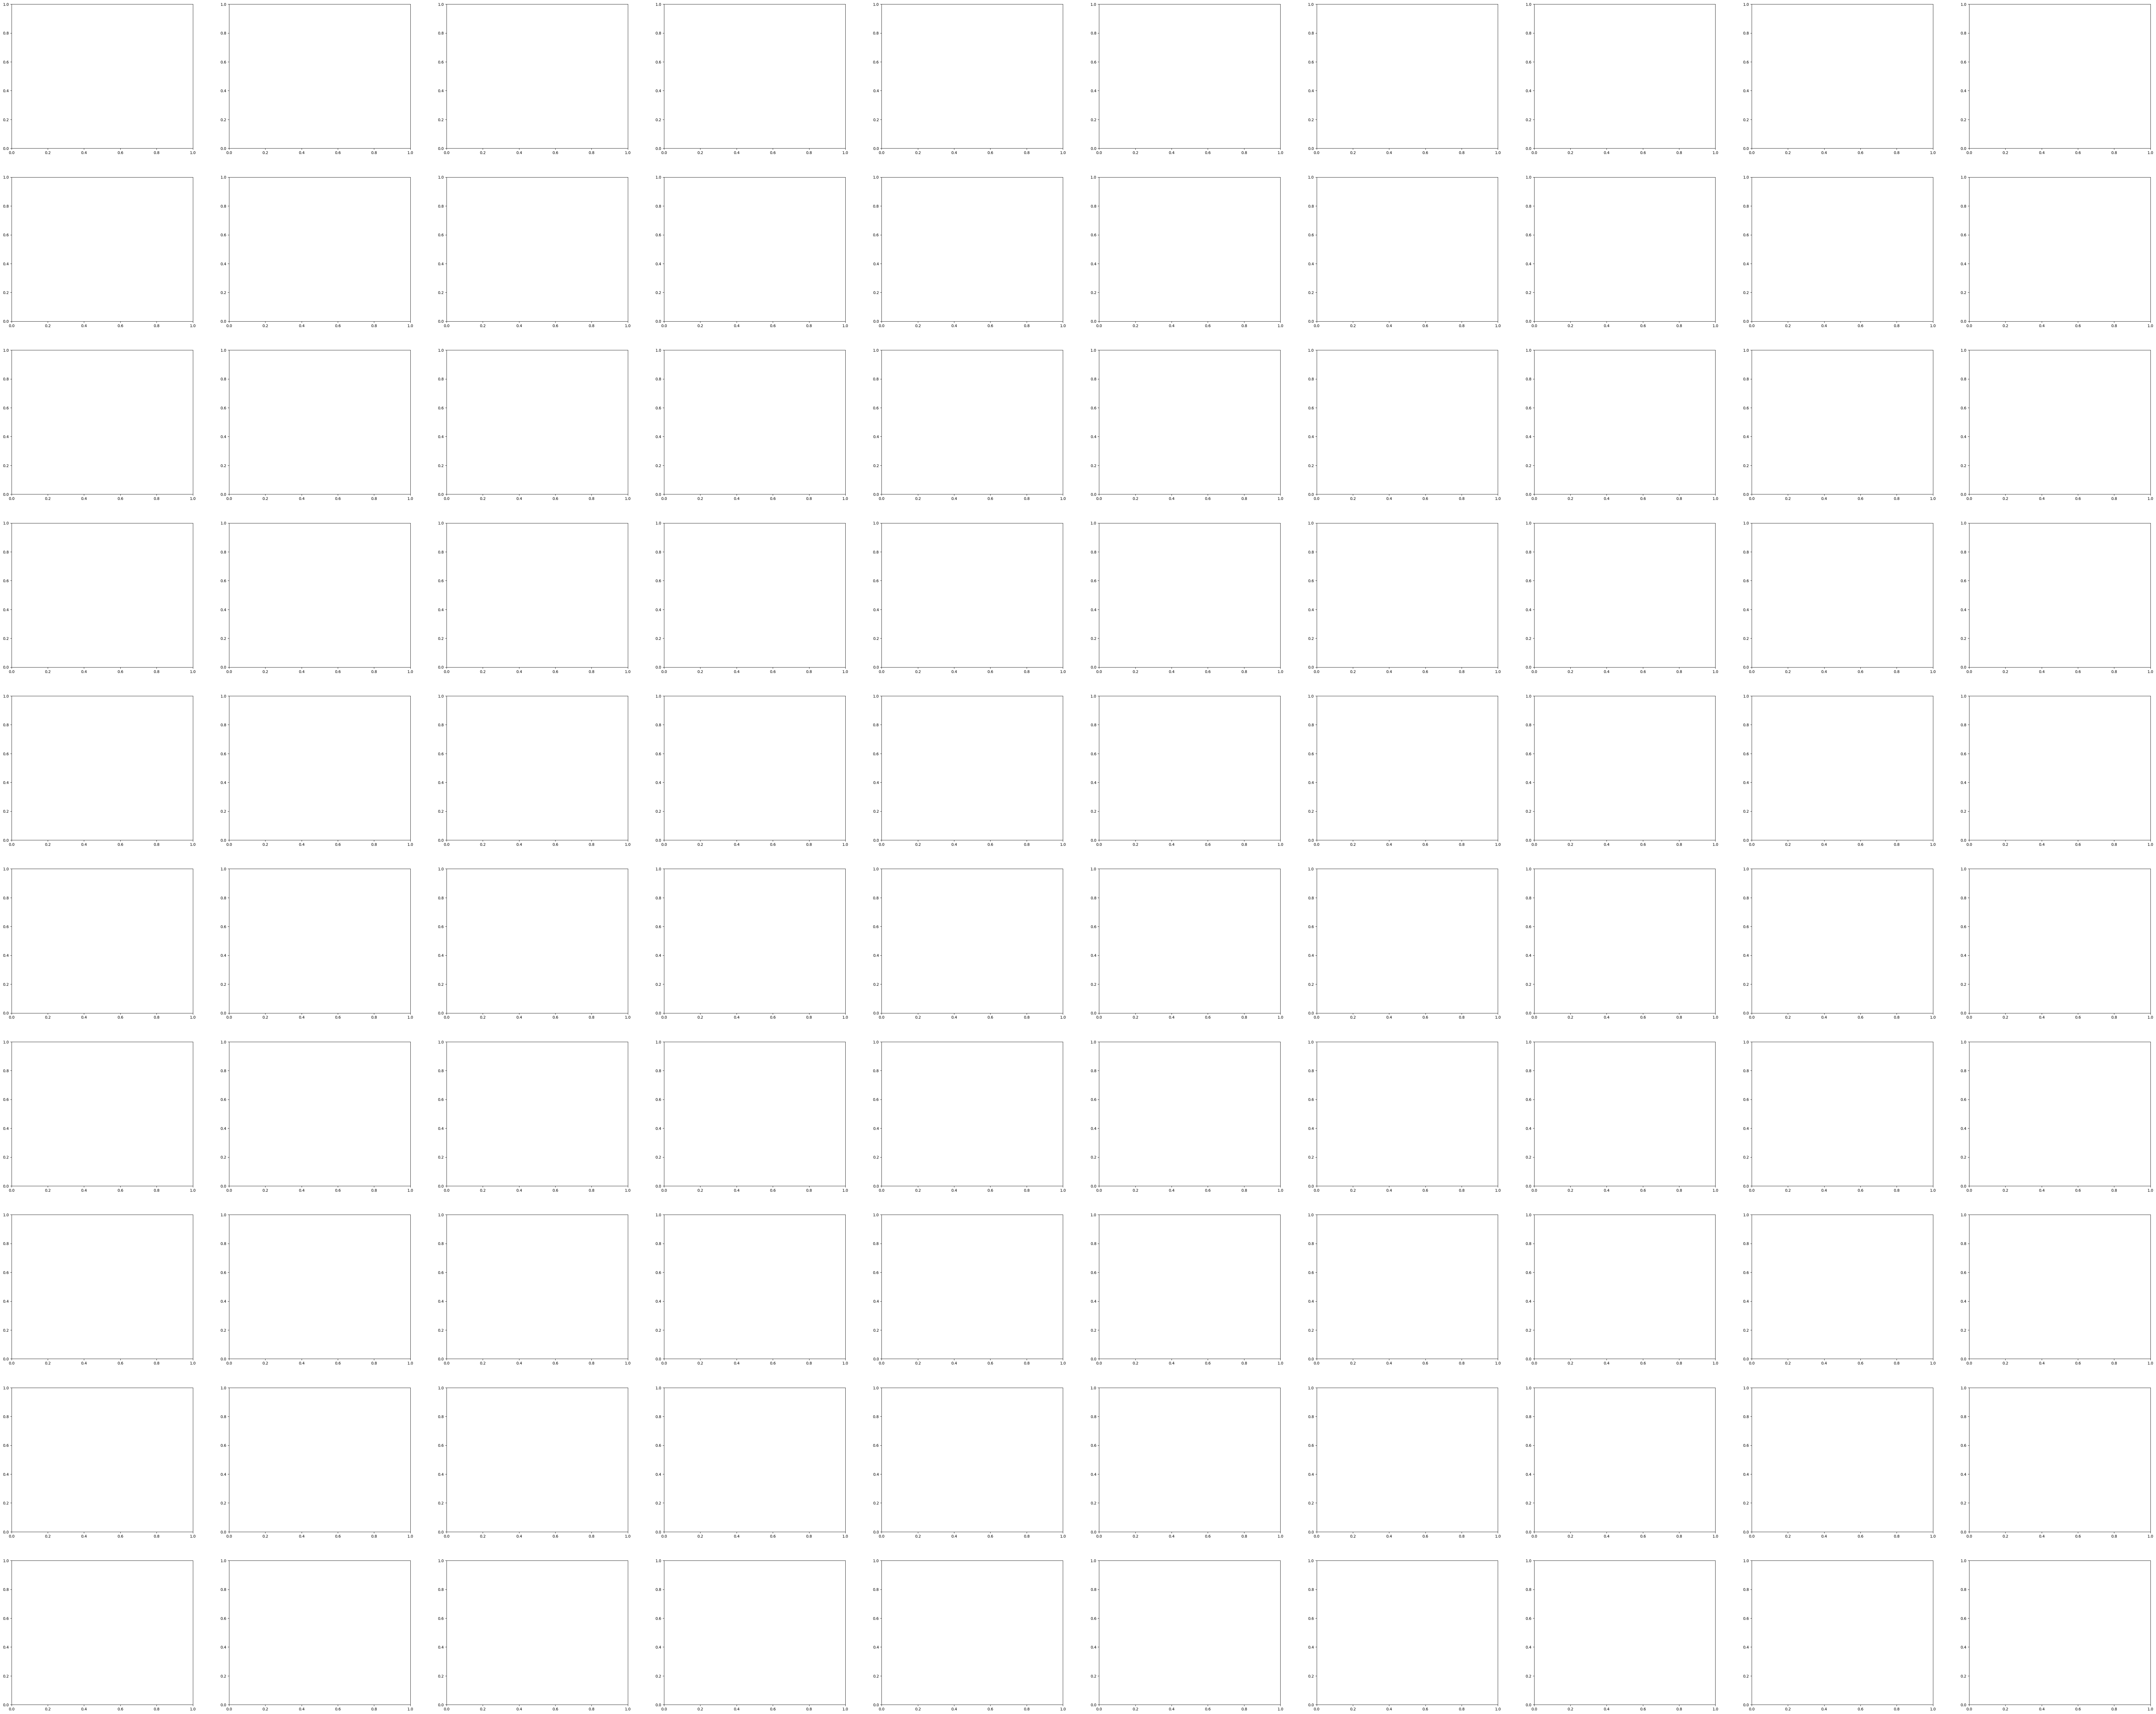

In [9]:
num_viz_samples = 10
assert aux_info['multi_label'] is False

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)
visualize_results(gsat, all_viz_set, test_set, num_viz_samples, dataset_name, model_config['use_edge_attr'])